# Install Libraries

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=1a221903ed06dc8ecb5e65635db334b064a55f26cd4ccb13f35914e89fb34ecb
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


/tmp/ipykernel_47/42517732.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


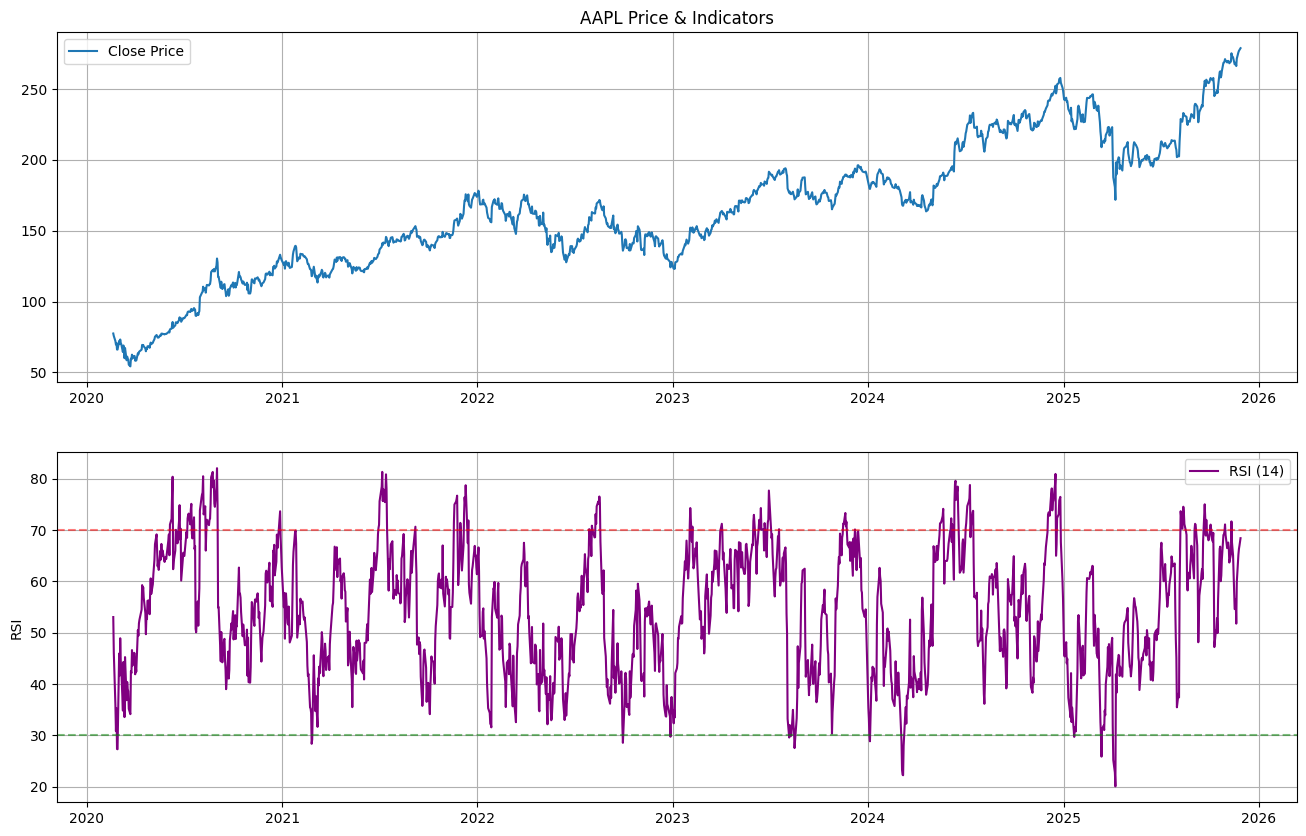


Success! Data shape matches requirements.
Price            Close        RSI      MACD
Date                                       
2025-11-21  271.489990  59.852250  3.179848
2025-11-24  275.920013  65.170242  3.476455
2025-11-25  276.970001  66.309334  3.752981
2025-11-26  277.549988  66.952271  3.973130
2025-11-28  278.850006  68.407589  4.204039


In [1]:

# 1. Install Library
!pip install ta

import pandas as pd
import ta
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

# 2. Setup and Download Data
ticker = 'AAPL' 
start_date = '2020-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

print(f"Downloading data for {ticker}...")
df = yf.download(ticker, start=start_date, end=end_date)


# If the data comes as MultiIndex or 2D (due to yfinance updates), we fix it here.
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

# Extract the 'Close' column as a 1D Series.
# The .squeeze() method converts data from shape (rows, 1) to (rows, )
close_series = df['Close'].squeeze()


# 3. Calculate Indicators

# A. RSI
# Now we pass 'close_series' (which is 1D) to the function
df['RSI'] = ta.momentum.rsi(close_series, window=14)

# B. MACD
# Calculate MACD using the 1D series
macd_object = ta.trend.MACD(close=close_series, window_slow=26, window_fast=12, window_sign=9)

df['MACD'] = macd_object.macd()
df['MACD_Signal'] = macd_object.macd_signal()
df['MACD_Diff'] = macd_object.macd_diff()

# 4. Data Cleaning
# Drop NaN values created by indicator calculations
df = df.dropna()

# 5. Visualization
plt.figure(figsize=(16, 10))

# Subplot 1: Price
plt.subplot(2, 1, 1)
plt.plot(df['Close'], label='Close Price')
plt.title(f'{ticker} Price & Indicators')
plt.legend()
plt.grid(True)

# Subplot 2: RSI
plt.subplot(2, 1, 2)
plt.plot(df['RSI'], color='purple', label='RSI (14)')
plt.axhline(70, color='red', linestyle='--', alpha=0.5) # Overbought line
plt.axhline(30, color='green', linestyle='--', alpha=0.5) # Oversold line
plt.ylabel('RSI')
plt.legend()
plt.grid(True)

plt.show()

print("\nSuccess! Data shape matches requirements.")
print(df[['Close', 'RSI', 'MACD']].tail())

# Data Preprocessing

In [2]:
# Step 2

from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 1. Select Features
# We want to predict 'Close' using 'Close', 'RSI', and 'MACD'
feature_columns = ['Close', 'RSI', 'MACD']
dataset = df[feature_columns].values

# 2. Scaling
# We use two scalers:
# scaler: For input features (Close, RSI, MACD)
# target_scaler: Only for the target (Close Price) - easier for inverse transform later

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler.fit(df[['Close']])

# 3. Create Sequences (Sliding Window)
prediction_days = 60
x_train = []
y_train = []

# Loop to create sequences
for i in range(prediction_days, len(scaled_data)):
    # Input: Past 60 days of ALL 3 features (Close, RSI, MACD)
    x_train.append(scaled_data[i-prediction_days:i, :])
    
    # Target: The Close Price of the current day (Column index 0 is Close)
    y_train.append(scaled_data[i, 0])

# Convert to Numpy Arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# 4. Verify Shapes
# The shape must be (samples, 60, 3) because we have 3 features now.
print(f"x_train shape: {x_train.shape}") 
print(f"y_train shape: {y_train.shape}")

x_train shape: (1393, 60, 3)
y_train shape: (1393,)


# Build & Train Multivariate LSTM

In [3]:
# Step 3

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()

# Layer 1: 
# input_shape=(60, 3) -> Automatically detected from x_train
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))

# Layer 2
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(units=1)) # Prediction of the Close Price

# Compile
model.compile(optimizer='adam', loss='mean_squared_error')

# Train
print("Starting training...")
# Training for 50 epochs to capture complex patterns
history = model.fit(x_train, y_train, batch_size=32, epochs=50)

print("Training completed!")

2025-12-01 13:54:47.403694: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764597287.847910      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764597287.970266      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

I0000 00:00:1764597308.242824      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764597308.243496      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Starting training...
Epoch 1/50


I0000 00:00:1764597312.442206     134 cuda_dnn.cc:529] Loaded cuDNN version 90300


44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1053
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0052
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0037
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028
Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025
Epoch 16/50
44/44 ━━━━━━━━━━━

In [4]:
# Step 4: Predict the Next Day's Price (Multivariate)

# 1. Get the last 60 days of data
# This slice includes all 3 features: Close, RSI, and MACD
last_60_days = scaled_data[-60:]

# 2. Reshape the data for the model
# Shape becomes (1, 60, 3) -> (1 sample, 60 days, 3 features)
X_future = np.array([last_60_days])
X_future = np.reshape(X_future, (X_future.shape[0], X_future.shape[1], 3))

# 3. Make the prediction
predicted_scaled_price = model.predict(X_future)

# 4. Inverse Transform (Convert back to USD)
# We use 'target_scaler' because the output corresponds only to the 'Close' column
predicted_price = target_scaler.inverse_transform(predicted_scaled_price)

print(f"\n=======================================================")
print(f"Multivariate Model Prediction: $ {predicted_price[0][0]:.2f}")
print(f"=======================================================")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step

Multivariate Model Prediction: $ 279.63


# Visualize the Multivariate Model Performance

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


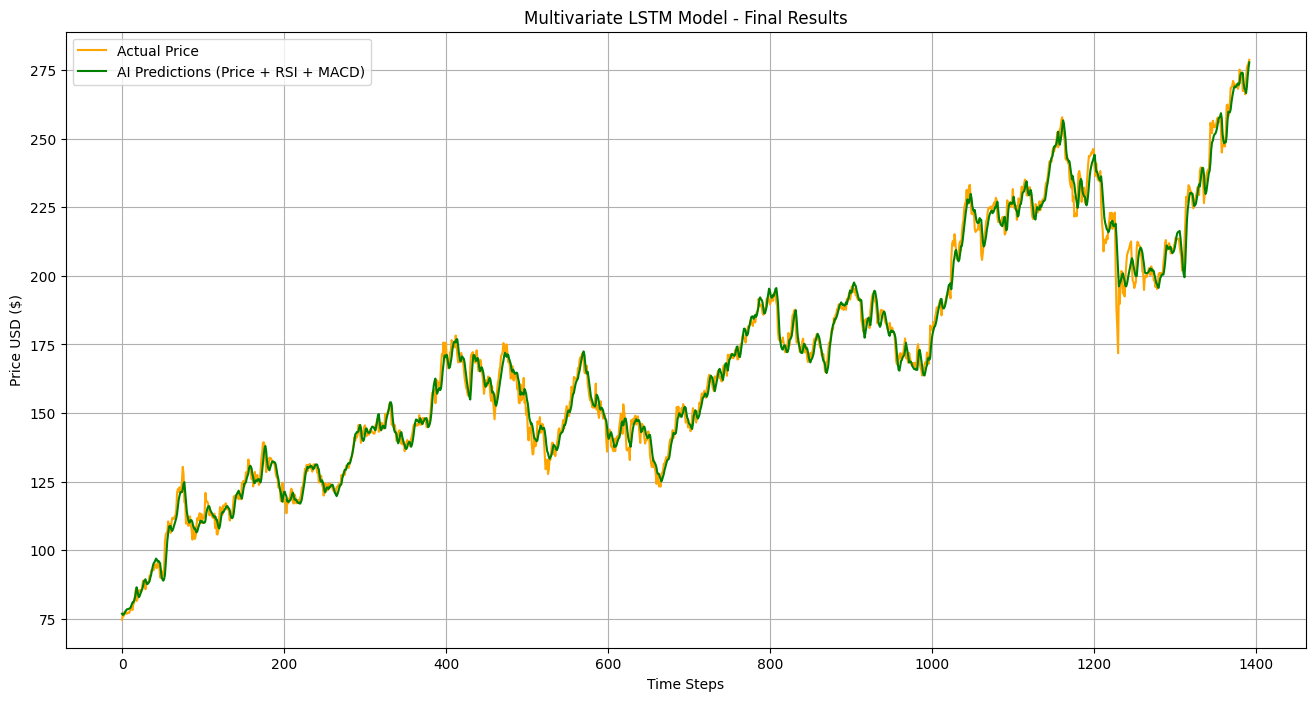

In [5]:

# 1. Predict on the training data to see how well it learned
predictions = model.predict(x_train)

# 2. Inverse Transform (Back to USD)
# We use target_scaler because the output is only 1 column (Price)
predictions_usd = target_scaler.inverse_transform(predictions)

# 3. Get the actual prices for comparison
# We shift by 'prediction_days' to align with predictions
actual_prices = target_scaler.inverse_transform(y_train.reshape(-1, 1))

# 4. Plot
plt.figure(figsize=(16, 8))
plt.title('Multivariate LSTM Model - Final Results')
plt.plot(actual_prices, color='orange', label='Actual Price')
plt.plot(predictions_usd, color='green', label='AI Predictions (Price + RSI + MACD)')
plt.xlabel('Time Steps')
plt.ylabel('Price USD ($)')
plt.legend()
plt.grid(True)
plt.show()